In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from art.metrics import empirical_robustness
from thundersvm import SVC as ThunderSVC
from art.estimators.classification.scikitlearn import ScikitlearnSVC

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch, halfspace_synthesis, uncertainty_synthesis, random_synthesis, halfspace_synthesis_matlab
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

In [2]:
def stopping_func(learner, metrics):
    return learner.X_training.shape[0] > 400

In [83]:
import libadversarial; reload(libadversarial); from libadversarial import halfspace_synthesis

## Halfspace synthesis ref test (against matlab)

Testing to make sure the python port gives the same results as the original matlab implementation (via FFI).

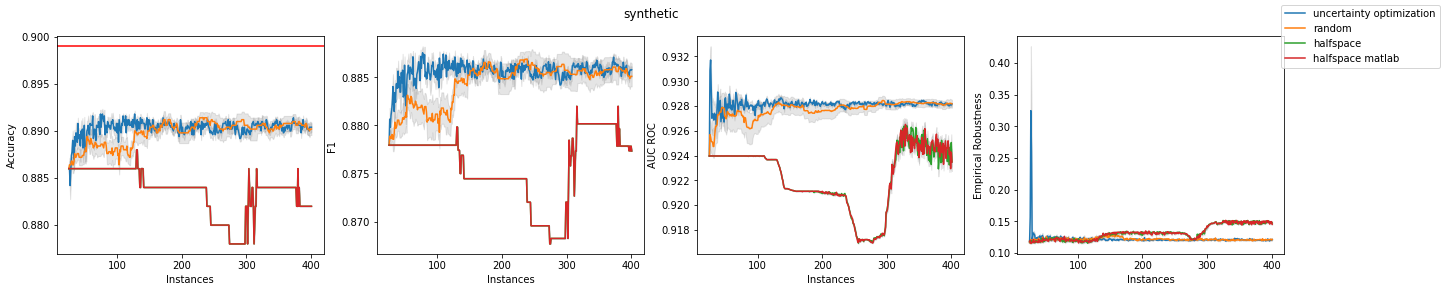

In [118]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "synthetic": lambda: lru_cache(generateData_twoPills_2D)(dataset_size=1000),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "halfspace": partial(halfspace_synthesis, n_instances=1),
        "halfspace matlab": partial(halfspace_synthesis_matlab, n_instances=1),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        try:
            metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv", index_col=0)
            stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv", index_col=0)
        except FileNotFoundError:
            metrics = ProgressParallel(n_jobs=3, total=10, desc=f"Run", leave=False)(
                delayed(
                    lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func)
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
                for _ in range(10)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv")
            stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()

## Halfspace synthesis performance test

These datasets are not realizable, which is a key assumption in the halfspace method. Because of this the method performs poorly 'real world' tests.

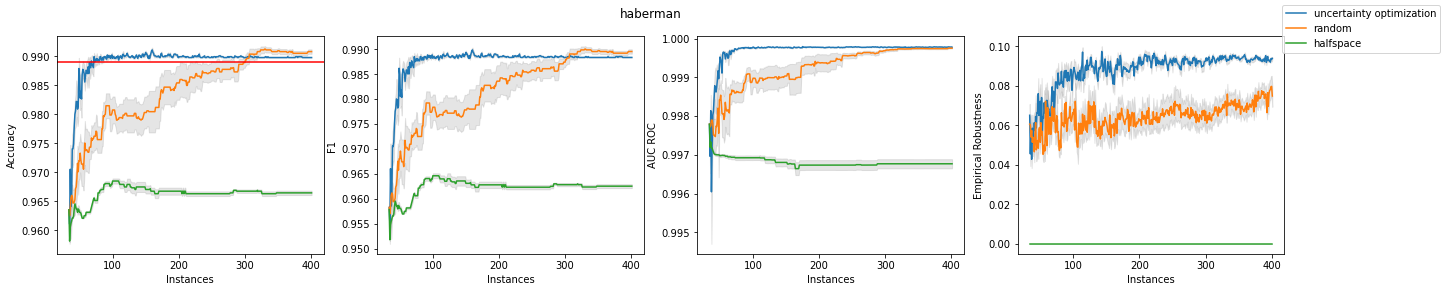

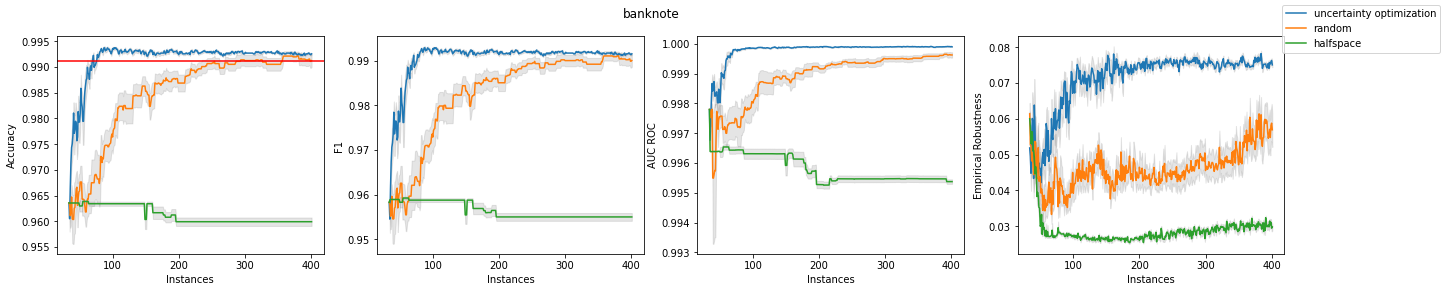

In [90]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "halfspace": partial(halfspace_synthesis, n_instances=1),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 4, figsize=(22,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        try:
            metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv", index_col=0)
            stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv", index_col=0)
        except FileNotFoundError:
            metrics = ProgressParallel(n_jobs=3, total=10, desc=f"Run", leave=False)(
                delayed(
                    lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness]).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func, track_flips=True)
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
                for _ in range(10)
            )
            metrics, stderr = metrics[0].average(metrics[1:])
            metrics.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv")
            stderr.to_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend()

In [23]:
reload(libadversarial); from libadversarial import halfspace_synthesis

## Halfspace synthesis synthetic gif

Here we can see some interesting parts of the algorithm:

* It queries a large number of points in a very small area to reduce the version space
* It is susceptable to noise in the oracle (not present here, addressed in another paper)
* As this dataset is not realizable it bounces between a couple of divisons at the end (after refining the decision boundary a bit).

In [24]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "synthetic": lambda: lru_cache(generateData_twoPills_2D)(dataset_size=1000),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "halfspace": partial(halfspace_synthesis, n_instances=1),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        try:
            metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv", index_col=0)
            stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv", index_col=0)
            raise FileNotFoundError()
        except FileNotFoundError:
            metrics = ProgressParallel(n_jobs=1, total=1, desc=f"Run", leave=False)(
                delayed(
                    lambda X_biased, X_unlabelled, y_biased, y_oracle, X_test, y_test, method: MyActiveLearner(metrics=[accuracy_score, f1_score, roc_auc_score, empirical_robustness], animate=True).active_learn_query_synthesis(X_biased, y_biased, lambda x: oracle.predict(x), X_test, y_test, method, stopping_func)
                )(X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test, method)
                for _ in range(1)
            )

Plot of the synthetic dataset for reference

2021-01-14 09:56:12,872 - py.warnings - WARNING - c:\users\zac\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



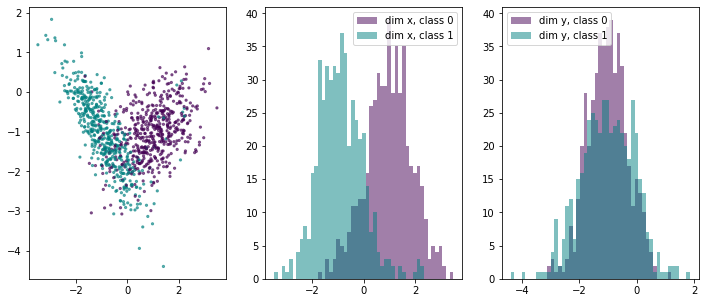

In [26]:
plot_dataset_2D(X,y)